In [1]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/data/parth-data/Level5_WP/"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [3]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable
os.environ["L5KIT_DATA_FOLDER"] = "/data/parth-data/Level5_WP/"
# get config
cfg = load_config_data("./visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


In [4]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False
set_origin_to_bottom:True


In [5]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [6]:
from l5kit.environment.utils import get_scene_types, get_scene_types_as_dict
from l5kit.dataset import EgoDataset

rasterizer = build_rasterizer(cfg, dm)


scene_id_to_type_mapping_file = "../../dataset_metadata/train_split_1350.csv"
scene_id_to_type_val_path = "../../dataset_metadata/val_split_1350.csv"

# Group Structures
scene_type_to_id_dict = get_scene_types_as_dict(scene_id_to_type_mapping_file)
scene_id_to_type_list = get_scene_types(scene_id_to_type_mapping_file)

train_dataset_original = EgoDataset(cfg, zarr_dataset, rasterizer)
cumulative_sizes = train_dataset_original.cumulative_sizes


In [7]:
# Loop over scenes
total_frames = cumulative_sizes[-1]
cumulative_sizes = np.insert(cumulative_sizes, 0, 0)
filter_frame_ids = [False] * total_frames
for index in range(len(cumulative_sizes)-1):
    # Determine boundaries
    start_frame = cumulative_sizes[index]
    end_frame = cumulative_sizes[index+1]
    len_scene = end_frame - start_frame
    if scene_id_to_type_list[index][0] == 'lower':
        filter_frame_ids[start_frame : end_frame] = [True] * len_scene    
filtered_frames = [i for i, x in enumerate(filter_frame_ids) if x]
chosen_frames = filtered_frames

In [65]:
ratio = 0.005
step = 5

In [66]:
frames_to_use = range(0, int(ratio * len(filtered_frames)), step)
scene_samples = [train_dataset_original.get_frame_indices(filtered_frames[f]) for f in frames_to_use]
scene_samples = np.concatenate(scene_samples).ravel()
scene_samples = np.sort(scene_samples)

In [67]:
chosen_frames = scene_samples

Total Lower Frames:  920


getting centroid to plot trajectory: 100%|█████| 920/920 [00:00<00:00, 202911.06it/s]


(-2500.0, -1000.0)

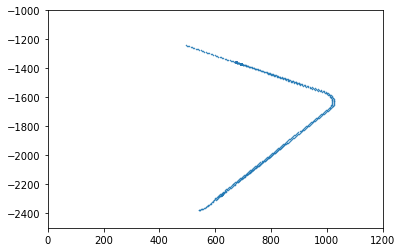

In [68]:
frames = zarr_dataset.frames[chosen_frames]
coords = np.zeros((len(frames), 2))
print("Total Lower Frames: ", len(frames))

for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.', s=1)
axes = plt.gca()
axes.set_xlim([0, 1200])
axes.set_ylim([-2500, -1000])

Total Lower Frames:  919265
Ratio Lower Frames:  0.0054391279989992
Stop at Frames:  4596
Batches:  7


getting centroid to plot trajectory: 100%|█████████████| 920/920 [00:00<00:00, 505735.21it/s]


(-2500.0, 1600.0)

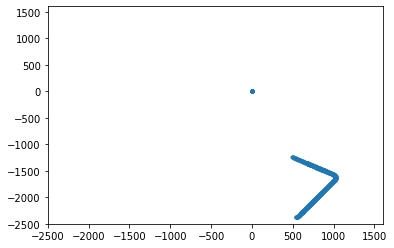

In [30]:
frames = zarr_dataset.frames[filtered_frames]
coords = np.zeros((len(frames), 2))
print("Total Lower Frames: ", len(frames))
start = 0
step = 5
stop = 5000
print("Ratio Lower Frames: ", 5000.0 / len(frames))
stop = int(0.005 * len(frames))
print("Stop at Frames: ", stop)

batch_size = 128
print("Batches: ", stop // (batch_size * step))



for idx_coord, idx_data in enumerate(tqdm(range(start, stop, step), desc="getting centroid to plot trajectory")):
    frame = frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])